## Siemens star

A Siemens star is a target used to test the resolution of a system see this [Wikipedia entry](https://en.wikipedia.org/wiki/Siemens_star).  This excersise was inspired by this [twitter post](https://twitter.com/RunningPhoton/status/1513049141055668225) and by [this Matlab example](https://github.com/jdmanton/rl_positivity_sim).  

The test images can be found [here](http://bigwww.epfl.ch/deconvolution/data/siemens-star/)

## Define functions for PSF, forward model and RIchardson Lucy

This example has been designed to work in a conda environment that has numpy, matplotlib and skimage, and doesn't need complicated dependencies.  To make this example relatively independent of the experimental modules, In this block we define functions for

1.  A forward model -> Convolution + Poisson Noise
2.  A paraxial PSF
3.  2D Richardson Lucy (on the CPU) using Numpy
4.  A 2d image plotting helper

The paraxial PSF function and forward model function were inspired by Matlab code by James Maton that can be found [here](https://github.com/jdmanton/rl_positivity_sim)

In [13]:
import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift
from numpy.random import poisson
import matplotlib.pyplot as plt

def forward(field, psf, max_photons, background_level, add_poisson=True):
    '''
        Note this function inspired by code from https://github.com/jdmanton/rl_positivity_sim by James Manton
    '''
    otf = fftn(fftshift(psf))
    field_imaged = ifftn(fftn(field)*otf)
    field_imaged = field_imaged/field_imaged.max()
    field_imaged = field_imaged*max_photons+background_level

    if add_poisson:
        return poisson(field_imaged.astype(float))
    else:
        return field_imaged.astype(float)

def richardson_lucy_np(image, psf, num_iters, save_interval):
    estimates=[]
    estimates.append(image)
    
    otf = fftn(fftshift(psf))
    otf_ = np.conjugate(otf)    
    estimate = image#np.ones(image.shape)/image.sum()

    for i in range(num_iters):
        #print(i)
        
        reblurred = ifftn(fftn(estimate) * otf)
        ratio = image / (reblurred + 1e-30)
        estimate = estimate * (ifftn(fftn(ratio) * otf_)).astype(float)
        
        if i%10==0:
            print(i, end=" ")
            
        if i%save_interval==0:
            estimates.append(estimate)
                    
    return np.stack(estimates)

def paraxial_otf(n, wavelength, numerical_aperture, pixel_size):
    '''
        Note this function inspired by code from https://github.com/jdmanton/rl_positivity_sim by James Manton
    '''
    nx, ny=(n,n)
    
    resolution  = 0.5 * wavelength / numerical_aperture

    image_centre_x = n / 2 + 1
    image_centre_y = n / 2 + 1

    x=np.linspace(0,nx-1,nx)
    y=np.linspace(0,ny-1,ny)
    x=x-image_centre_x
    y=y-image_centre_y

    X, Y = np.meshgrid(x,y)

    filter_radius = 2 * pixel_size / resolution
    r = np.sqrt(X*X+Y*Y)
    r=r/x.max()
    v=r/filter_radius
    v = v * (r<=filter_radius)
    otf = 2 / np.pi * (np.arccos(v) - v * np.sqrt(1 - v*v))*(r<=filter_radius);
    
    return otf

def paraxial_psf(n, wavelength, numerical_aperture, pixel_size):
    otf = paraxial_otf(n, wavelength, numerical_aperture, pixel_size)
    psf = fftshift(ifftn(ifftshift(otf)).astype(np.float32))
    return psf/psf.sum()

def imshow2d(im, width=8, height=6):
    fig, ax = plt.subplots(figsize=(width,height))
    ax.imshow(im)
    return fig


## Get and open test images

1.  Get images from this folder https://www.dropbox.com/sh/v3g5zln64e0uhk7/AABcYksPoawlTBO9ELCyqfPOa?dl=0
2.  In the code snippet below change ```im_path``` to the local location on your machine where you put the above folder

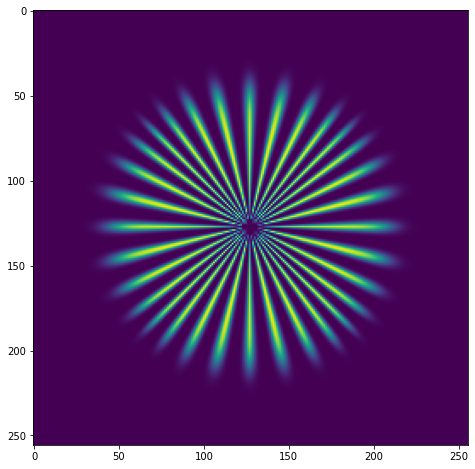

In [14]:
from skimage.io import imread

im_path='D:/images/i2k2022/deconvolution/'
truth_name='star.tif'

truth=imread(im_path+truth_name)

truth=truth.astype('float32')

fig=imshow2d(truth, 8, 8)

## Create the PSF

Now create the PSF.  After running the entire notebook once, as an exercise change the pixel size and run all the down stream components again.  What happens with a pixel size of 100 nm?  What about 20 nm?  How do you explain what you see?

C:\Users\bnort\AppData\Local\Temp\ipykernel_18668\1478592741.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  psf = fftshift(ifftn(ifftshift(otf)).astype(np.float32))


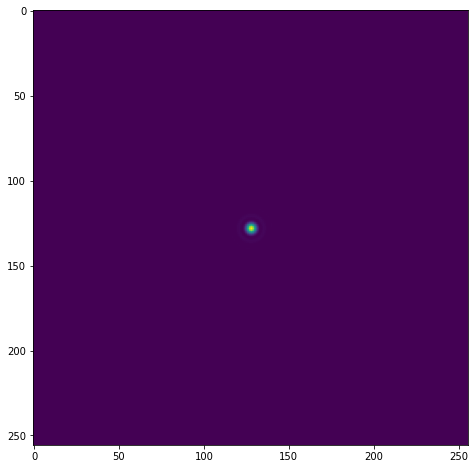

In [15]:
n=truth.shape[0]
wavelength = 500
na=1.4
pixel_size = 40

psf=paraxial_psf(n, wavelength, na, pixel_size)

fig=imshow2d(psf,8,8)

## Apply the forward model

The forward model is convolution with a microscope PSF and the addition of Poisson noise.   Increasing max photons and/or decreasing background level will change the amount of noise in the image.  Change these parameters and rerun the downstream components and observe what happens.

C:\Users\bnort\AppData\Local\Temp\ipykernel_18668\1478592741.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  return poisson(field_imaged.astype(float))


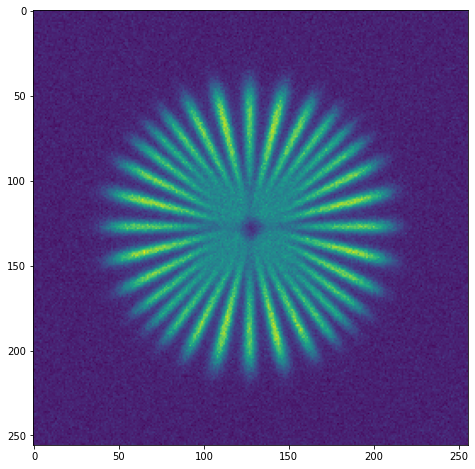

In [16]:
im = forward(truth, psf,max_photons=300.,background_level=100., add_poisson=True).astype('float32')
fig = imshow2d(im,8,8)

## Perform Deconvolution

In [17]:
num_iterations=200
decons = richardson_lucy_np(im, psf.astype('float32'), num_iterations, 1)

C:\Users\bnort\AppData\Local\Temp\ipykernel_18668\1478592741.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  estimate = estimate * (ifftn(fftn(ratio) * otf_)).astype(float)


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 

# Create arrays for truth and img

Create replicate arrays for the turth and im (forward).  We do this so that when we visualize all the iterations we can toggle the deconvolution and quickly compare to truth and img.  

In [7]:
from numpy import matlib
truth_array=matlib.repeat(truth[None,...],num_iterations,axis=0)
im_array=matlib.repeat(im[None,...],num_iterations,axis=0)

## Create a segmenter

Create a segmenter function that will be used to try and segment the blades of the star.  It is not a perfectly optimized segment function, however it works pretty good.  The main purpose is to try and see if we get better segmentation results after deconvolution and at what iteration we get the best segmentation.  As an exercise create a better 'blade' segmenter. 

In [8]:
from skimage.filters import difference_of_gaussians
from skimage.morphology import closing, disk
from skimage.measure import label

def segmenter(im,sigma=3):
    bw=im>threshold_otsu(im)
    #bw=closing(bw,disk(3))

    test=difference_of_gaussians(bw.astype('uint8'),sigma)
    test[test<0]=0
    bw=test>threshold_otsu(test)
    return label(bw)

## Create thresholded and labeled images at each iteration

Here we loop through all the deconvolved iterations and create a thresholded (using a simple Otsu) and labeled (using our segmenter defined above) result for each iterations

In [9]:
from skimage.filters import threshold_otsu

otsus=[]
labels=[]
for i in range(decons.shape[0]):
    otsus.append(decons[i,:,:]>threshold_otsu(decons[i,:,:]))
    labels.append(segmenter(decons[i,:,:],2))
labels=np.stack(labels)  
otsus=np.stack(otsus)


## Connect the 2d Segmentation in 3D

Here we call a function that will connect 2d objects to nearby 2d objects in the next plane.  This function was developed by Varun Kapoor with help from Volker H. in this [discussion](https://forum.image.sc/t/2d-3d-integer-labels/38732/41?page=3)

In [11]:
try:
    from tnia.morphology.connect import connect_2d_in_3d
    labels=connect_2d_in_3d(labels,10)
    
except ImportError:
    print('The TNIA library was not imported.  Cannot connect 2D to 3D')
    print('This is not critical, the unconnected labels will be used for visualization')


## Visualize in Napari

Now we visualize in Napari.  In this case our dataset is 3D, but the 3rd dimension isn't spatial, it's 'iteration'.  We can scroll through the iterations and see how our deconvolution and segmentations evolve with respect to iteration number. 

In [12]:
import napari
viewer=napari.Viewer()
viewer.add_image(truth_array)
viewer.add_image(im_array)
viewer.add_image(decons)
viewer.add_labels(labels)
viewer.add_labels(otsus)

C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'otsus' at 0x1a2fe1b18b0>

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\asyncio\base_events.py", line 623, in run_until_complete
    self._check_running()
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\asyncio\base_events.py", line 585, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\zmq\eventloop\zmqstream.

In [48]:
type(relabels)

NoneType